In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from PIL import Image
import requests
from sklearn.preprocessing import OneHotEncoder
import cv2 as cv
import rasterio
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import copy

## Set Data Directory. You can download data from this link - https://drive.google.com/file/d/19hkPfaRAK891VwkgPUPek4tADaJX6M1H/view?usp=sharing

In [2]:
data_dir = '../satellite_images/'

In [3]:
def makedir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [4]:
savedir = 'data_processed'
makedir(savedir)

## Preprocess data

In [5]:
doc_df = pd.read_excel('DateofCollection_2022.xlsx')
doc_2022 = {}
for index, row in doc_df.iterrows():
    if row['Location'] not in doc_2022.keys():
        doc_2022[row['Location']] = {}
    doc_2022[row['Location']][row['time']] = row['Date']
save_path = os.path.join(savedir, 'doc_2022.pkl')
f = open(save_path,'wb')
pickle.dump(doc_2022,f)
f.close()

doc_df = pd.read_excel('DateofCollection_2023.xlsx')
doc_2023 = {}
for index, row in doc_df.iterrows():
    if row['Location'] not in doc_2023.keys():
        doc_2023[row['Location']] = {}
    doc_2023[row['Location']][row['time']] = row['Date']
save_path = os.path.join(savedir, 'doc_2023.pkl')
f = open(save_path,'wb')
pickle.dump(doc_2023,f)
f.close()

In [6]:
data_list = []
columns = ['year', 'location', 'irrigationProvided', 'experiment', 'range', 'row', 'N_level', 'genotype', 'planting_date', 'yield']

df_2022 = pd.read_csv('HYBRID_HIPS_V3.5_ALLPLOTS.csv')

df_2022 = df_2022.drop(columns = ['index', 'qrCode','poundsOfNitrogenPerAcre','plotLength', 'block','plotNumber','totalStandCount', 'daysToAnthesis', 'GDDToAnthesis'])
df_2022 = df_2022.dropna()

for index, row in df_2022.iterrows():
    new_row = []
    new_row.append('2022')
    new_row.append(row['location'])
    new_row.append(row['irrigationProvided'])
    new_row.append(row['experiment'])
    new_row.append(row['range'])
    new_row.append(row['row'])
    new_row.append(row['nitrogenTreatment'])
    new_row.append(row['genotype'])
    new_row.append(row['plantingDate'])
    new_row.append(row['yieldPerAcre'])
    data_list.append(new_row)

df_train_2023 = pd.read_csv('train_HIPS_HYBRIDS_2023_V2.3.csv')

df_train_2023 = df_train_2023.drop(columns = ['qrCode','poundsOfNitrogenPerAcre','plotLength', 'block','plotNumber','totalStandCount', 'daysToAnthesis', 'GDDToAnthesis'])
df_train_2023 = df_train_2023.dropna()

for index, row in df_train_2023.iterrows():
    new_row = []
    new_row.append('2023')
    new_row.append(row['location'])
    new_row.append(row['irrigationProvided'])
    new_row.append(row['experiment'])
    new_row.append(row['range'])
    new_row.append(row['row'])
    new_row.append(row['nitrogenTreatment'])
    new_row.append(row['genotype'])
    new_row.append(row['plantingDate'])
    new_row.append(row['yieldPerAcre'])
    data_list.append(new_row)

total_count = len(data_list)

random.shuffle(data_list)

num_train = int(0.8*total_count)
train_list = data_list[:num_train]
val_list = data_list[num_train:]
print(len(train_list), len(val_list))

data_split_dict = {'columns': columns,'train': train_list, 'val': val_list}

f = open(os.path.join(savedir,'data_split.pkl'), 'wb')
pickle.dump(data_split_dict,f)
f.close()

f = open(os.path.join(savedir,'train_split.csv'),'w')
f.write(','.join(columns)+'\n')
for line in data_split_dict['train']:
    f.write(','.join([str(l) for l in line])+'\n')
f.close()

f = open(os.path.join(savedir,'val_split.csv'),'w')
f.write(','.join(columns)+'\n')
for line in data_split_dict['val']:
    f.write(','.join([str(l) for l in line])+'\n')
f.close()

2219 555


In [7]:
data_list = []
columns = ['year', 'location', 'irrigationProvided', 'experiment', 'range', 'row', 'N_level', 'genotype', 'planting_date']+['location_Ames', 'location_Crawfordsville', 'location_Lincoln', 'location_MOValley'] + ['N_level_High', 'N_level_Low', 'N_level_Medium']

df_val_2023 = pd.read_csv('val_HIPS_HYBRIDS_2023_V2.3.csv')
print(df_val_2023['plotLength'].value_counts())

df_val_2023 = df_val_2023.drop(columns = ['qrCode','poundsOfNitrogenPerAcre','plotLength', 'block','plotNumber','totalStandCount', 'daysToAnthesis', 'GDDToAnthesis', 'yieldPerAcre'])

for index, row in df_val_2023.iterrows():
    new_row = []
    new_row.append('2023')
    new_row.append(row['location'])
    new_row.append(row['irrigationProvided'])
    new_row.append(row['experiment'])
    new_row.append(row['range'])
    new_row.append(row['row'])
    new_row.append(row['nitrogenTreatment'])
    new_row.append(row['genotype'])
    new_row.append(row['plantingDate'])
    new_row += [1.0, 0.0, 0.0, 0.0]
    if row['nitrogenTreatment'] == 'Low':
        new_row += [0.0, 1.0, 0.0]
    if row['nitrogenTreatment'] == 'High':
        new_row += [1.0, 0.0, 0.0]
    if row['nitrogenTreatment'] == 'Medium':
        new_row += [0.0, 0.0, 1.0]
    data_list.append(new_row)

total_count = len(data_list)
data_split_dict = {'columns': columns, 'val': data_list}

f = open(os.path.join(savedir,'val_2023.pkl'), 'wb')
pickle.dump(data_split_dict,f)
f.close()

f = open(os.path.join(savedir,'val_2023.csv'),'w')
f.write(','.join(columns)+'\n')
for line in data_split_dict['val']:
    f.write(','.join([str(l) for l in line])+'\n')
f.close()

17.5    282
Name: plotLength, dtype: int64


In [8]:
data_list = []
columns = ['year', 'location', 'irrigationProvided', 'experiment', 'range', 'row', 'N_level', 'genotype', 'planting_date']+['location_Ames', 'location_Crawfordsville', 'location_Lincoln', 'location_MOValley'] + ['N_level_High', 'N_level_Low', 'N_level_Medium']

df_test_2023 = pd.read_csv('test_HIPS_HYBRIDS_2023_V2.3.csv')
print(df_test_2023['plotLength'].value_counts())

df_test_2023 = df_test_2023.drop(columns = ['qrCode','poundsOfNitrogenPerAcre','plotLength', 'block','plotNumber','totalStandCount', 'daysToAnthesis', 'GDDToAnthesis', 'yieldPerAcre'])

for index, row in df_test_2023.iterrows():
    new_row = []
    new_row.append('2023')
    new_row.append(row['location'])
    new_row.append(row['irrigationProvided'])
    new_row.append(row['experiment'])
    new_row.append(row['range'])
    new_row.append(row['row'])
    new_row.append(row['nitrogenTreatment'])
    new_row.append(row['genotype'])
    new_row.append(row['plantingDate'])
    new_row += [1.0, 0.0, 0.0, 0.0]
    if row['nitrogenTreatment'] == 'Low':
        new_row += [0.0, 1.0, 0.0]
    if row['nitrogenTreatment'] == 'High':
        new_row += [1.0, 0.0, 0.0]
    if row['nitrogenTreatment'] == 'Medium':
        new_row += [0.0, 0.0, 1.0]
    data_list.append(new_row)

total_count = len(data_list)
data_split_dict = {'columns': columns, 'val': data_list}

f = open(os.path.join(savedir,'test_2023.pkl'), 'wb')
pickle.dump(data_split_dict,f)
f.close()

f = open(os.path.join(savedir,'test_2023.csv'),'w')
f.write(','.join(columns)+'\n')
for line in data_split_dict['val']:
    f.write(','.join([str(l) for l in line])+'\n')
f.close()

17.5    288
Name: plotLength, dtype: int64


## Prepare training data

In [9]:
f = open('bandwise_minmax.pkl', 'rb')
minmax = pickle.load(f)
f.close()

def makedir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def norm(band, index):
  band_min, band_max = minmax[index]['min'], minmax[index]['max']
  return ((band - band_min)/(band_max - band_min))

def get_image(image_path):
  src = rasterio.open(image_path, 'r')
  S_images=src.read()
  c0 = norm(S_images[0].astype(np.float32), 0)
  c1 = norm(S_images[1].astype(np.float32), 1)
  c2 = norm(S_images[2].astype(np.float32), 2)
  c3 = norm(S_images[3].astype(np.float32), 3)
  c4 = norm(S_images[4].astype(np.float32), 4)
  c5 = norm(S_images[5].astype(np.float32), 5)
  image = np.dstack((c0,c1,c2,c3,c4,c5))
  src.close()
  return image

def process_image(satellite_image):
  satellite_image = satellite_image[2:-2, 2:-2, :]
  h,w,c = satellite_image.shape
  if w < h:
    satellite_image = np.transpose(satellite_image, (1, 0, 2))
  resized_image = cv.resize(satellite_image, (25, 25), interpolation=cv.INTER_CUBIC)
  return resized_image

def get_age(year, location, time_point, planting_date):
  collection_date = doc[str(year)][location][time_point]
  planting_date = pd.to_datetime(planting_date)
  collection_date = pd.to_datetime(collection_date)
  return (collection_date-planting_date).days

train_split = pd.read_csv(os.path.join(savedir,'train_split.csv'))
val_split = pd.read_csv(os.path.join(savedir,'val_split.csv'))

f = open(os.path.join(savedir,'doc_2022.pkl'), 'rb')
doc_2022 = pickle.load(f)
f.close()
f = open(os.path.join(savedir,'doc_2023.pkl'), 'rb')
doc_2023 = pickle.load(f)
f.close()
f = open(os.path.join(savedir,'data_split.pkl'), 'rb')
data_split = pickle.load(f)
f.close()

doc = {}
doc['2022'] = doc_2022
doc['2023'] = doc_2023
doc['2022']['MOValley'] = doc['2022']['Missouri Valley']

all_data = pd.concat([train_split, val_split])

metadata = {}

all_data = all_data[all_data.location != 'Scottsbluff']
all_data = all_data.drop(columns=['genotype','irrigationProvided'])
metadata['max_yield'] = all_data['yield'].max()
all_data['yield'] = all_data['yield'] / all_data['yield'].max()

encoder = OneHotEncoder(handle_unknown='ignore')
encoded_data = encoder.fit_transform(all_data[['location', 'N_level']])
encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_data, columns=encoder.get_feature_names_out(['location', 'N_level']))
all_data = all_data.reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)
all_data_encoded = pd.concat([all_data, encoded_df], axis=1)

all_data_encoded = all_data_encoded.drop(['N_level'], axis=1)

In [10]:
train_df, val_df = train_test_split(all_data_encoded, test_size=0.2, random_state=42)

- Test set age: 0.12602739726027398
0.19726027397260273
0.2821917808219178

In [11]:
train_images = {'age0':[], 'age1':[], 'age2':[], 'age3':[]}
train_numerical_features = {'age0':[], 'age1':[], 'age2':[], 'age3':[]}
train_targets = {'age0':[], 'age1':[], 'age2':[], 'age3':[]}
age1 = 0.14; age2 = 0.26; age3 = 0.35

for index, row in tqdm(train_df.iterrows()):

  location = row['location']
  year = row['year']
  if year == 2023:
    year = '2023_train'
  experiment = row['experiment']
  if experiment == 'Hyrbrids':
    experiment = 'Hybrids'
  range_ = row['range']
  row_ = row['row']
  planting_date = row['planting_date']
  time_points = sorted(os.listdir(os.path.join(data_dir, str(year), location)))

  for time_point in time_points:
    folder_path = os.path.join(data_dir, str(year), location, time_point)
    image_name = f'{location}-{time_point}-{experiment}_{range_}_{row_}.TIF'
    image_path = os.path.join(folder_path, image_name)
    if os.path.exists(image_path):
        satellite_image = get_image(image_path)
        processed_image = process_image(satellite_image)
        age = get_age(row['year'], location, time_point, planting_date)
        age = age/365

        if age<=age1:
            age_group = 'age0'
        elif age<=age2:
            age_group = 'age1'
        elif age<=age3:
            age_group = 'age2'
        else:
            age_group = 'age3'
              
        train_images[age_group].append(processed_image)
        train_numerical_features[age_group].append([
                                                 row['N_level_High'],
                                                 row['N_level_Low'],
                                                 row['N_level_Medium'],
                                                 age])
        train_targets[age_group].append(row['yield'])
          
    else:
      print(image_path)

for age_group in ['age0', 'age1', 'age2', 'age3']:
    train_images[age_group] = np.array(train_images[age_group])
    train_numerical_features[age_group] = np.array(train_numerical_features[age_group])
    train_targets[age_group] = np.array(train_targets[age_group])



val_images = {'age0':[], 'age1':[], 'age2':[], 'age3':[]}
val_numerical_features = {'age0':[], 'age1':[], 'age2':[], 'age3':[]}
val_targets = {'age0':[], 'age1':[], 'age2':[], 'age3':[]}

for index, row in tqdm(val_df.iterrows()):

  location = row['location']
  year = row['year']
  if year == 2023:
    year = '2023_train'
  experiment = row['experiment']
  if experiment == 'Hyrbrids':
    experiment = 'Hybrids'
  range_ = row['range']
  row_ = row['row']
  planting_date = row['planting_date']
  time_points = sorted(os.listdir(os.path.join(data_dir, str(year), location)))

  for time_point in time_points:
    folder_path = os.path.join(data_dir, str(year), location, time_point)
    image_name = f'{location}-{time_point}-{experiment}_{range_}_{row_}.TIF'
    image_path = os.path.join(folder_path, image_name)
    if os.path.exists(image_path):
        satellite_image = get_image(image_path)
        processed_image = process_image(satellite_image)
        age = get_age(row['year'], location, time_point, planting_date)
        age = age/365
        
        if age<=age1:
            age_group = 'age0'
        elif age<=age2:
            age_group = 'age1'
        elif age<=age3:
            age_group = 'age2'
        else:
            age_group = 'age3'
              
        val_images[age_group].append(processed_image)
        val_numerical_features[age_group].append([
                                                 row['N_level_High'],
                                                 row['N_level_Low'],
                                                 row['N_level_Medium'],
                                                 age])
        val_targets[age_group].append(row['yield'])
              
    else:
      print(image_path)

for age_group in ['age0', 'age1', 'age2', 'age3']:
    val_images[age_group] = np.array(train_images[age_group])
    val_numerical_features[age_group] = np.array(train_numerical_features[age_group])
    val_targets[age_group] = np.array(train_targets[age_group])


0it [00:00, ?it/s]/Users/sejeong/anaconda3/lib/python3.11/site-packages/tqdm/std.py:1178: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  for obj in iterable:
1828it [00:46, 38.98it/s]
457it [00:11, 38.59it/s]


In [12]:
data_dict = {}

for age_group in ['age0', 'age1', 'age2', 'age3']:
    data_dict[age_group] = {'train_images': train_images[age_group],
             'train_numerical_features': train_numerical_features[age_group],
             'train_targets': train_targets[age_group],
             'val_images': val_images[age_group],
             'val_numerical_features': val_numerical_features[age_group],
             'val_targets': val_targets[age_group],
             'metadata': metadata}

f = open('processed_data_train_val.pkl', 'wb')
pickle.dump(data_dict, f)
f.close()

- val set age: 0.12602739726027398
0.19726027397260273
0.2821917808219178

In [13]:
val_2023_split = pd.read_csv('data_processed/val_2023.csv')

f = open('data_processed/val_2023.pkl', 'rb')
data_split = pickle.load(f)
f.close()

all_data = val_2023_split

with open('processed_data_train_val.pkl', 'rb') as f:
  processed_data = pickle.load(f)

max_yield = processed_data['age0']['metadata']['max_yield']
all_data = all_data.drop(columns=['genotype','irrigationProvided'])

images = {'age0':[], 'age1':[], 'age2':[]}
numerical_features = {'age0':[], 'age1':[], 'age2':[]}

for index, row in tqdm(all_data.iterrows()):

  location = row['location']
  year = row['year']
  if year == 2023:
    year = '2023_val'
  experiment = row['experiment']
  if experiment == 'Hyrbrids':
    experiment = 'Hybrids'
  range_ = row['range']
  row_ = row['row']
  planting_date = row['planting_date']
  time_points = sorted(os.listdir(os.path.join(data_dir, str(year), location)))

  new_images = []
  new_numerical_features = []  
  for time_point in time_points:
    folder_path = os.path.join(data_dir, str(year), location, time_point)
    image_name = f'{location}-{time_point}-{experiment}_{range_}_{row_}.TIF'
    image_path = os.path.join(folder_path, image_name)
    if os.path.exists(image_path):
      satellite_image = get_image(image_path)
      processed_image = process_image(satellite_image)
      age = get_age(row['year'], location, time_point, planting_date)
      age = age/365

        
      if time_point == 'TP1':
        age_group = 'age0'
      elif time_point == 'TP2':
        age_group = 'age1'
      else: 
        age_group = 'age2'
      images[age_group].append(processed_image)
      numerical_features[age_group].append([
                     row['N_level_High'],
                     row['N_level_Low'],
                     row['N_level_Medium'],
                     age])
      print('found ',image_path)  
    else:
      print('not_found', image_path)

for age_group in ['age0', 'age1', 'age2']:
    images[age_group] = np.array(images[age_group])
    numerical_features[age_group] = np.array(numerical_features[age_group])

data_dict = {}
for age_group in ['age0', 'age1', 'age2']:
    data_dict[age_group] = {'images': images[age_group],
                         'numerical_features': numerical_features[age_group],
                         'metadata': processed_data['age0']['metadata']}

f = open('processed_val_2023_data.pkl', 'wb')
pickle.dump(data_dict, f)
f.close()

7it [00:00, 62.77it/s]

found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_12_11.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_12_11.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_12_11.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_3_13.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_3_13.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_3_13.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_18_13.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_18_13.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_18_13.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_2_15.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_2_15.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_2_15.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_5_15.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_5_15.TIF
found  ../satellite_images/2023_val/Ames/T

21it [00:00, 66.28it/s]

found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_2_11.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_12_17.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_12_17.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_12_17.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_11_17.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_11_17.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_11_17.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_4_15.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_4_15.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_4_15.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_20_13.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_20_13.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_20_13.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_22_17.TIF
found  ../satellite_images/2023_val/Am

35it [00:00, 67.71it/s]

found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_17_13.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_21_11.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_21_11.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_21_11.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_19_15.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_19_15.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_19_15.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_20_15.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_20_15.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_20_15.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_19_11.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_19_11.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_19_11.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_12_15.TIF
found  ../satellite_images/2023_va

49it [00:00, 67.76it/s]

found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_36_13.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_36_13.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_45_15.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_45_15.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_45_15.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_30_15.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_30_15.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_30_15.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_24_13.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_24_13.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_24_13.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_27_15.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_27_15.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_27_15.TIF
found  ../satellite_images/2023_va

63it [00:00, 67.76it/s]

found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_34_17.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_34_17.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_32_13.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_32_13.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_32_13.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_41_17.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_41_17.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_41_17.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_25_13.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_25_13.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_25_13.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_44_17.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_44_17.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_44_17.TIF
found  ../satellite_images/2023_va

77it [00:01, 67.90it/s]

found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_38_15.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_38_15.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_38_15.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_32_11.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_32_11.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_32_11.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_39_13.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_39_13.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_39_13.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_42_13.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_42_13.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2315_42_13.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2315_24_11.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2315_24_11.TIF
found  ../satellite_images/2023_va

91it [00:01, 67.67it/s]

found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_4_37.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_4_37.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_4_37.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_10_37.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_10_37.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_10_37.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_13_37.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_13_37.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_13_37.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_7_35.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_7_35.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_7_35.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_21_31.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_21_31.TIF
found  ../satellite_images/2023_val/Ames

105it [00:01, 68.08it/s]

found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_9_31.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_2_39.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_2_39.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_2_39.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_18_35.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_18_35.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_18_35.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_18_31.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_18_31.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_18_31.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_6_33.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_6_33.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_6_33.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_6_37.TIF
found  ../satellite_images/2023_val/Ames/T

119it [00:01, 67.66it/s]

found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_9_37.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_13_35.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_13_35.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_13_35.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_2_31.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_2_31.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_2_31.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_5_39.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_5_39.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_5_39.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_10_33.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_10_33.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_10_33.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_8_39.TIF
found  ../satellite_images/2023_val/Ames/T

133it [00:01, 67.99it/s]

found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_20_37.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_20_37.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_5_35.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_5_35.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_5_35.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_17_41.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_17_41.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_17_41.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_17_39.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_17_39.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_17_39.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_15_31.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_15_31.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_15_31.TIF
found  ../satellite_images/2023_val/A

147it [00:02, 67.67it/s]

found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_21_41.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_21_41.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_21_41.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_11_41.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_11_41.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_11_41.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_3_35.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_3_35.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_3_35.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_23_41.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_23_41.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_23_41.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_33_37.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_33_37.TIF
found  ../satellite_images/2023_val/A

161it [00:02, 67.95it/s]

found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_29_39.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_28_35.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_28_35.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_28_35.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_33_35.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_33_35.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_33_35.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_34_35.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_34_35.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_34_35.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_37_37.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_37_37.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_37_37.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_41_37.TIF
found  ../satellite_images/2023_va

175it [00:02, 68.03it/s]

found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_31_33.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_29_33.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_29_33.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_29_33.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_41_33.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_41_33.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_41_33.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_42_31.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_42_31.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_42_31.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_37_41.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_37_41.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_37_41.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_38_41.TIF
found  ../satellite_images/2023_va

189it [00:02, 67.90it/s]

found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_23_33.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_38_39.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_38_39.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_38_39.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_41_35.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_41_35.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_41_35.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_28_33.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_28_33.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_28_33.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_35_41.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_35_41.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_35_41.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_36_39.TIF
found  ../satellite_images/2023_va

203it [00:03, 67.93it/s]

found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_27_39.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_27_39.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_26_41.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_26_41.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_26_41.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_34_41.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_34_41.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_34_41.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_33_39.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_33_39.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_33_39.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2325_25_33.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2325_25_33.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2325_25_33.TIF
found  ../satellite_images/2023_va

217it [00:03, 67.97it/s]

found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_6_55.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_6_55.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2335_6_59.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_6_59.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_6_59.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2335_20_59.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_20_59.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_20_59.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2335_4_55.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_4_55.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_4_55.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2335_12_59.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_12_59.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_12_59.TIF
found  ../satellite_images/2023_val/Ames/T

231it [00:03, 68.18it/s]

found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_15_55.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_15_55.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2335_21_59.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_21_59.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_21_59.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2335_12_61.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_12_61.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_12_61.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2335_21_57.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_21_57.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_21_57.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2335_22_61.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_22_61.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_22_61.TIF
found  ../satellite_images/2023_va

245it [00:03, 68.30it/s]

found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_9_55.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_9_55.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2335_10_61.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_10_61.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_10_61.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2335_13_55.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_13_55.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_13_55.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2335_22_55.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_22_55.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_22_55.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2335_8_55.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_8_55.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_8_55.TIF
found  ../satellite_images/2023_val/Ame

259it [00:03, 68.92it/s]

found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_28_59.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_28_59.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2335_29_55.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_29_55.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_29_55.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2335_31_55.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_31_55.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_31_55.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2335_30_55.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_30_55.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_30_55.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2335_32_57.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_32_57.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_32_57.TIF
found  ../satellite_images/2023_va

273it [00:04, 68.77it/s]

found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_39_57.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_39_57.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2335_42_61.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_42_61.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_42_61.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2335_35_59.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_35_59.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_35_59.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2335_30_59.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_30_59.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_30_59.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2335_33_61.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_33_61.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_33_61.TIF
found  ../satellite_images/2023_va

282it [00:04, 67.94it/s]

found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_39_61.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_39_61.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2335_42_59.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_42_59.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_42_59.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2335_36_61.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_36_61.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_36_61.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2335_32_61.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_32_61.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_32_61.TIF
found  ../satellite_images/2023_val/Ames/TP1/Ames-TP1-2335_45_59.TIF
found  ../satellite_images/2023_val/Ames/TP2/Ames-TP2-2335_45_59.TIF
found  ../satellite_images/2023_val/Ames/TP3/Ames-TP3-2335_45_59.TIF


- Test set age: {0.12602739726027398, 0.19726027397260273, 0.2821917808219178}

In [14]:
test_2023_split = pd.read_csv('data_processed/test_2023.csv')

f = open('data_processed/doc_2023.pkl', 'rb')
doc_2023 = pickle.load(f)
f.close()
f = open('data_processed/test_2023.pkl', 'rb')
data_split = pickle.load(f)
f.close()

all_data = test_2023_split

with open('processed_data_train_val.pkl', 'rb') as f:
  processed_data = pickle.load(f)

max_yield = processed_data['age0']['metadata']['max_yield']
all_data = all_data.drop(columns=['genotype','irrigationProvided'])

images = {'age0':[], 'age1':[], 'age2':[]}
numerical_features = {'age0':[], 'age1':[], 'age2':[]}

for index, row in tqdm(all_data.iterrows()):

  location = row['location']
  year = row['year']
  if year == 2023:
    year = '2023_test'
  experiment = row['experiment']
  if experiment == 'Hyrbrids':
    experiment = 'Hybrids'
  range_ = row['range']
  row_ = row['row']
  planting_date = row['planting_date']
  time_points = sorted(os.listdir(os.path.join(data_dir, str(year), location)))

  for time_point in time_points:
    if time_point == 'TP1':
        age_group = 'age0'
    elif time_point == 'TP2':
        age_group = 'age1'
    else: 
        age_group = 'age2'
        
    folder_path = os.path.join(data_dir, str(year), location, time_point)
    image_name = f'{location}-{time_point}-{experiment}_{range_}_{row_}.TIF'
    image_path = os.path.join(folder_path, image_name)
    if os.path.exists(image_path):
      satellite_image = get_image(image_path)
      processed_image = process_image(satellite_image)
      age = get_age(row['year'], location, time_point, planting_date)
      age = age/365
      images[age_group].append(processed_image)
      numerical_features[age_group].append([
                     row['N_level_High'],
                     row['N_level_Low'],
                     row['N_level_Medium'],
                     age])
      print('found ',image_path)  
    else:
      print('not_found', image_path)

for age_group in ['age0', 'age1', 'age2']:
    images[age_group] = np.array(images[age_group])
    numerical_features[age_group] = np.array(numerical_features[age_group])

data_dict = {}
for age_group in ['age0', 'age1', 'age2']:
    data_dict[age_group] = {'images': images[age_group],
                         'numerical_features': numerical_features[age_group],
                         'metadata': processed_data['age0']['metadata']}

f = open('processed_test_2023_data.pkl', 'wb')
pickle.dump(data_dict, f)
f.close()

0it [00:00, ?it/s]

found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_9_15.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_9_15.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_9_15.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_7_11.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_7_11.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_7_11.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_4_17.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_4_17.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_4_17.TIF


7it [00:00, 63.61it/s]

found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_20_17.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_20_17.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_20_17.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_19_13.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_19_13.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_19_13.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_3_17.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_3_17.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_3_17.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_13_15.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_13_15.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_13_15.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_23_15.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_23_15.TIF
found  ../satellite_ima

14it [00:00, 65.79it/s]

found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_9_11.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_9_11.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_19_17.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_19_17.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_19_17.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_9_17.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_9_17.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_9_17.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_8_15.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_8_15.TIF


21it [00:00, 66.83it/s]

found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_8_15.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_9_13.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_9_13.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_9_13.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_17_17.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_17_17.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_17_17.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_14_15.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_14_15.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_14_15.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_11_15.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_11_15.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_11_15.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_2_17.TIF
found  ../satellite_image

28it [00:00, 67.23it/s]

found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_8_13.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_8_13.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_13_17.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_13_17.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_13_17.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_23_17.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_23_17.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_23_17.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_18_15.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_18_15.TIF


35it [00:00, 67.66it/s]

found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_18_15.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_15_11.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_15_11.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_15_11.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_16_15.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_16_15.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_16_15.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_17_11.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_17_11.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_17_11.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_8_11.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_8_11.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_8_11.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_23_13.TIF
found  ../satellite_ima

42it [00:00, 67.87it/s]

found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_2_13.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_2_13.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_39_15.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_39_15.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_39_15.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_33_13.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_33_13.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_33_13.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_35_15.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_35_15.TIF


49it [00:00, 67.63it/s]

found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_35_15.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_39_11.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_39_11.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_39_11.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_44_15.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_44_15.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_44_15.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_33_15.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_33_15.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_33_15.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_35_17.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_35_17.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_35_17.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_37_17.TIF
found  ../satellite_

56it [00:00, 67.77it/s]

found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_45_17.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_45_17.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_45_17.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_25_11.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_25_11.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_25_11.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_40_17.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_40_17.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_40_17.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_30_17.TIF


63it [00:00, 67.63it/s]

found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_30_17.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_30_17.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_36_15.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_36_15.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_36_15.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_37_13.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_37_13.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_37_13.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_31_11.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_31_11.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_31_11.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_25_17.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_25_17.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_25_17.TIF
found  ../satellite_

70it [00:01, 67.10it/s]

found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_40_13.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_43_15.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_43_15.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_43_15.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_42_15.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_42_15.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_42_15.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_26_17.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_26_17.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_26_17.TIF


77it [00:01, 67.39it/s]

found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_31_15.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_31_15.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_31_15.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_43_11.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_43_11.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_43_11.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_34_11.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_34_11.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_34_11.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_30_11.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_30_11.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_30_11.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_32_15.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_32_15.TIF
found  ../satellite_

84it [00:01, 67.07it/s]

found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_30_13.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_30_13.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2315_41_11.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2315_41_11.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2315_41_11.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_15_37.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_15_37.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_15_37.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_13_31.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_13_31.TIF


91it [00:01, 67.26it/s]

found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_13_31.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_14_41.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_14_41.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_14_41.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_10_31.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_10_31.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_10_31.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_11_35.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_11_35.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_11_35.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_8_41.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_8_41.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_8_41.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_21_35.TIF
found  ../satellite_ima

98it [00:01, 66.60it/s]

found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_11_37.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_14_39.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_14_39.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_14_39.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_21_39.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_21_39.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_21_39.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_12_35.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_12_35.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_12_35.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_22_35.TIF


105it [00:01, 66.99it/s]

found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_22_35.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_22_35.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_6_39.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_6_39.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_6_39.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_12_31.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_12_31.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_12_31.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_15_33.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_15_33.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_15_33.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_9_33.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_9_33.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_9_33.TIF
found  ../satellite_images

112it [00:01, 67.00it/s]

found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_14_33.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_14_33.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_19_31.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_19_31.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_19_31.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_20_31.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_20_31.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_20_31.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_8_37.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_8_37.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_8_37.TIF


119it [00:01, 67.14it/s]

found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_9_39.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_9_39.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_9_39.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_4_31.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_4_31.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_4_31.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_6_31.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_6_31.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_6_31.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_7_39.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_7_39.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_7_39.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_8_33.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_8_33.TIF
found  ../satellite_images/2023_te

126it [00:01, 67.24it/s]

found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_3_31.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_3_31.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_3_31.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_17_35.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_17_35.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_17_35.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_18_33.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_18_33.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_18_33.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_13_33.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_13_33.TIF


133it [00:01, 67.38it/s]

found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_13_33.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_20_35.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_20_35.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_20_35.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_17_37.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_17_37.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_17_37.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_4_35.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_4_35.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_4_35.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_5_41.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_5_41.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_5_41.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_16_35.TIF
found  ../satellite_images

140it [00:02, 67.11it/s]

found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_7_37.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_21_37.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_21_37.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_21_37.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_12_37.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_12_37.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_12_37.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_4_41.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_4_41.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_4_41.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_19_35.TIF


147it [00:02, 67.01it/s]

found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_19_35.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_19_35.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_10_35.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_10_35.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_10_35.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_11_33.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_11_33.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_11_33.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_11_31.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_11_31.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_11_31.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_38_37.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_38_37.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_38_37.TIF
found  ../satellite_

154it [00:02, 66.94it/s]

found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_35_31.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_35_31.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_32_41.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_32_41.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_32_41.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_33_31.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_33_31.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_33_31.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_28_37.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_28_37.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_28_37.TIF


161it [00:02, 66.56it/s]

found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_35_35.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_35_35.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_35_35.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_30_31.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_30_31.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_30_31.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_31_41.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_31_41.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_31_41.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_34_37.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_34_37.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_34_37.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_42_35.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_42_35.TIF
found  ../satellite_

175it [00:02, 66.70it/s]

found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_39_37.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_39_37.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_24_41.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_24_41.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_24_41.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_32_37.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_32_37.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_32_37.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_25_37.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_25_37.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_25_37.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_37_31.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_37_31.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_37_31.TIF
found  ../satellite_

189it [00:02, 67.02it/s]

found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_30_39.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_30_39.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_30_39.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_40_41.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_40_41.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_40_41.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_25_35.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_25_35.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_25_35.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_42_39.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_42_39.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_42_39.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_25_39.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_25_39.TIF
found  ../satellite_

203it [00:03, 67.39it/s]

found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_24_39.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_26_33.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_26_33.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_26_33.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_30_33.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_30_33.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_30_33.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_36_31.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_36_31.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_36_31.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_26_37.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2325_26_37.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2325_26_37.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2325_36_37.TIF
found  ../satellite_

217it [00:03, 67.49it/s]

found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_14_57.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_14_57.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_13_57.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_13_57.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_13_57.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_5_61.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_5_61.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_5_61.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_5_55.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_5_55.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_5_55.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_6_57.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_6_57.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_6_57.TIF
found  ../satellite_images/20

231it [00:03, 67.68it/s]

found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_14_61.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_14_61.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_2_61.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_2_61.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_2_61.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_14_59.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_14_59.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_14_59.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_15_61.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_15_61.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_15_61.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_21_55.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_21_55.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_21_55.TIF
found  ../satellite_ima

245it [00:03, 67.92it/s]

found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_13_61.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_13_61.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_13_61.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_8_59.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_8_59.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_8_59.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_22_59.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_22_59.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_22_59.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_22_57.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_22_57.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_22_57.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_6_61.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_6_61.TIF
found  ../satellite_image

259it [00:03, 68.01it/s]

found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_24_57.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_38_61.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_38_61.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_38_61.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_30_61.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_30_61.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_30_61.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_27_61.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_27_61.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_27_61.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_27_55.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_27_55.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_27_55.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_28_57.TIF
found  ../satellite_

273it [00:04, 67.66it/s]

found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_43_57.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_33_57.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_33_57.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_33_57.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_26_61.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_26_61.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_26_61.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_25_59.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_25_59.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_25_59.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_33_59.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_33_59.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_33_59.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_41_57.TIF
found  ../satellite_

287it [00:04, 67.38it/s]

found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_31_59.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_31_59.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_24_61.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_24_61.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_24_61.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_34_55.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_34_55.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_34_55.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_25_61.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_25_61.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_25_61.TIF
found  ../satellite_images/2023_test/Ames/TP1/Ames-TP1-2335_40_61.TIF
found  ../satellite_images/2023_test/Ames/TP2/Ames-TP2-2335_40_61.TIF
found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_40_61.TIF
found  ../satellite_

288it [00:04, 67.25it/s]

found  ../satellite_images/2023_test/Ames/TP3/Ames-TP3-2335_40_59.TIF


## Define Model

In [15]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [16]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the custom dataset
class CustomDataset(Dataset):
    def __init__(self, images, numerical_features, targets):
        self.images = images
        self.numerical_features = numerical_features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        image = self.images[idx]
        numerical_feature = self.numerical_features[idx]
        target = self.targets[idx]
        return image, numerical_feature, target

# Define the regression model
class RegressionModel(nn.Module):
    def __init__(self, num_numerical_features):
        super(RegressionModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.flatten = nn.Flatten()
        # Calculate the correct input size for fc1
        self.fc1 = nn.Linear(64 * 3 * 3 + num_numerical_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, image, numerical_features):
        x = self.conv_layers(image)
        x = self.flatten(x)
        # Concatenate tensors
        x = torch.cat((x, numerical_features), dim=1)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.fc3(x)
        return x

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

# Function to plot learning curve
def plot_learning_curve(train_losses, val_losses):
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Learning Curve')
    plt.show()

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=7):
    train_losses = []
    val_losses = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, numerical_features, targets in train_loader:
            images, numerical_features, targets = images.to(device), numerical_features.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images, numerical_features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, numerical_features, targets in val_loader:
                images, numerical_features, targets = images.to(device), numerical_features.to(device), targets.to(device)
                outputs = model(images, numerical_features)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(torch.load('checkpoint.pt'))
    plot_learning_curve(train_losses, val_losses)
    return model

## Train

In [17]:
models = {}

In [18]:
with open('processed_data_train_val.pkl', 'rb') as f:
  data = pickle.load(f)

Epoch 1/300, Training Loss: 0.2244, Validation Loss: 0.2027
Validation loss decreased (inf --> 0.202657).  Saving model ...
Epoch 2/300, Training Loss: 0.1793, Validation Loss: 0.1483
Validation loss decreased (0.202657 --> 0.148329).  Saving model ...
Epoch 3/300, Training Loss: 0.1147, Validation Loss: 0.0701
Validation loss decreased (0.148329 --> 0.070104).  Saving model ...
Epoch 4/300, Training Loss: 0.0373, Validation Loss: 0.0134
Validation loss decreased (0.070104 --> 0.013411).  Saving model ...
Epoch 5/300, Training Loss: 0.0181, Validation Loss: 0.0159
EarlyStopping counter: 1 out of 7
Epoch 6/300, Training Loss: 0.0142, Validation Loss: 0.0144
EarlyStopping counter: 2 out of 7
Epoch 7/300, Training Loss: 0.0139, Validation Loss: 0.0133
Validation loss decreased (0.013411 --> 0.013328).  Saving model ...
Epoch 8/300, Training Loss: 0.0134, Validation Loss: 0.0134
EarlyStopping counter: 1 out of 7
Epoch 9/300, Training Loss: 0.0134, Validation Loss: 0.0133
Validation loss de

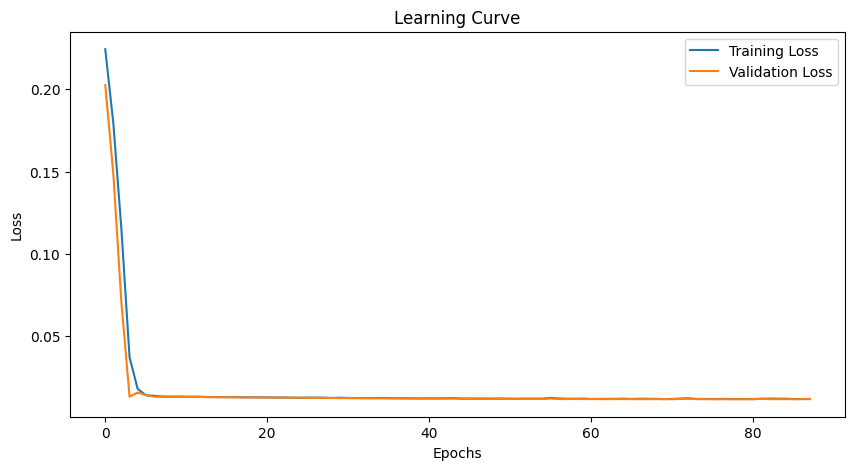

Epoch 1/300, Training Loss: 0.0863, Validation Loss: 0.0432
Validation loss decreased (inf --> 0.043204).  Saving model ...
Epoch 2/300, Training Loss: 0.0418, Validation Loss: 0.0406
Validation loss decreased (0.043204 --> 0.040609).  Saving model ...
Epoch 3/300, Training Loss: 0.0357, Validation Loss: 0.0284
Validation loss decreased (0.040609 --> 0.028398).  Saving model ...
Epoch 4/300, Training Loss: 0.0230, Validation Loss: 0.0207
Validation loss decreased (0.028398 --> 0.020676).  Saving model ...
Epoch 5/300, Training Loss: 0.0203, Validation Loss: 0.0196
Validation loss decreased (0.020676 --> 0.019553).  Saving model ...
Epoch 6/300, Training Loss: 0.0195, Validation Loss: 0.0195
Validation loss decreased (0.019553 --> 0.019540).  Saving model ...
Epoch 7/300, Training Loss: 0.0189, Validation Loss: 0.0181
Validation loss decreased (0.019540 --> 0.018073).  Saving model ...
Epoch 8/300, Training Loss: 0.0189, Validation Loss: 0.0178
Validation loss decreased (0.018073 --> 0.

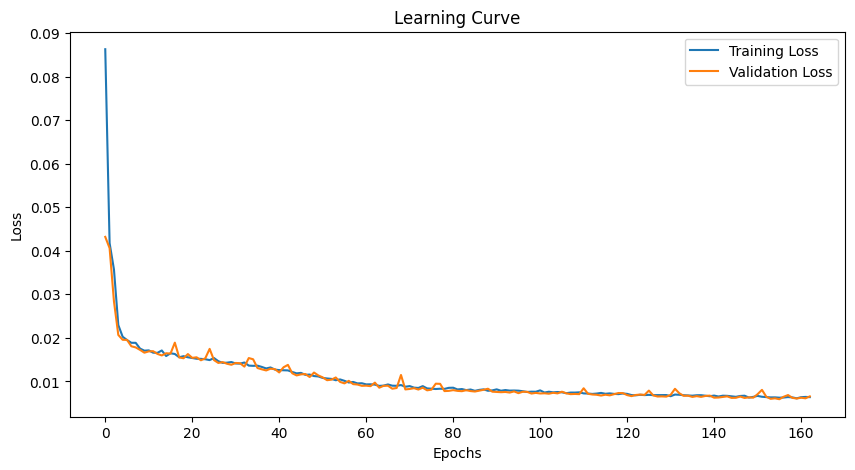

Epoch 1/300, Training Loss: 0.1207, Validation Loss: 0.0417
Validation loss decreased (inf --> 0.041711).  Saving model ...
Epoch 2/300, Training Loss: 0.0406, Validation Loss: 0.0397
Validation loss decreased (0.041711 --> 0.039746).  Saving model ...
Epoch 3/300, Training Loss: 0.0387, Validation Loss: 0.0379
Validation loss decreased (0.039746 --> 0.037887).  Saving model ...
Epoch 4/300, Training Loss: 0.0365, Validation Loss: 0.0361
Validation loss decreased (0.037887 --> 0.036102).  Saving model ...
Epoch 5/300, Training Loss: 0.0347, Validation Loss: 0.0339
Validation loss decreased (0.036102 --> 0.033941).  Saving model ...
Epoch 6/300, Training Loss: 0.0332, Validation Loss: 0.0340
EarlyStopping counter: 1 out of 7
Epoch 7/300, Training Loss: 0.0320, Validation Loss: 0.0310
Validation loss decreased (0.033941 --> 0.030990).  Saving model ...
Epoch 8/300, Training Loss: 0.0303, Validation Loss: 0.0301
Validation loss decreased (0.030990 --> 0.030089).  Saving model ...
Epoch 9/

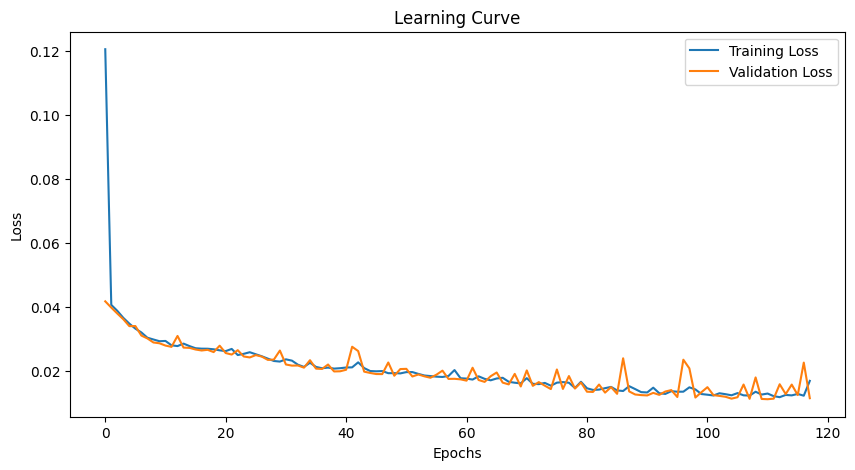

Epoch 1/300, Training Loss: 0.1469, Validation Loss: 0.0678
Validation loss decreased (inf --> 0.067808).  Saving model ...
Epoch 2/300, Training Loss: 0.0471, Validation Loss: 0.0450
Validation loss decreased (0.067808 --> 0.044951).  Saving model ...
Epoch 3/300, Training Loss: 0.0444, Validation Loss: 0.0444
Validation loss decreased (0.044951 --> 0.044388).  Saving model ...
Epoch 4/300, Training Loss: 0.0436, Validation Loss: 0.0429
Validation loss decreased (0.044388 --> 0.042900).  Saving model ...
Epoch 5/300, Training Loss: 0.0424, Validation Loss: 0.0417
Validation loss decreased (0.042900 --> 0.041714).  Saving model ...
Epoch 6/300, Training Loss: 0.0414, Validation Loss: 0.0404
Validation loss decreased (0.041714 --> 0.040406).  Saving model ...
Epoch 7/300, Training Loss: 0.0402, Validation Loss: 0.0412
EarlyStopping counter: 1 out of 7
Epoch 8/300, Training Loss: 0.0397, Validation Loss: 0.0385
Validation loss decreased (0.040406 --> 0.038529).  Saving model ...
Epoch 9/

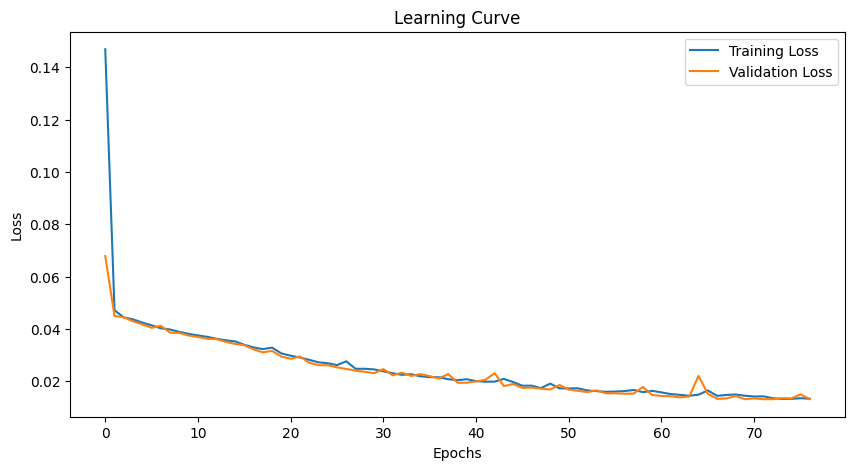

In [19]:
for age_group in ['age0', 'age1', 'age2', 'age3']:
    train_images = data[age_group]['train_images'].astype(np.float32)
    train_images = np.transpose(train_images, (0, 3, 1, 2))
    val_images = data[age_group]['val_images'].astype(np.float32)
    val_images = np.transpose(val_images, (0, 3, 1, 2))
    train_numerical_features = data[age_group]['train_numerical_features'].astype(np.float32)
    val_numerical_features = data[age_group]['val_numerical_features'].astype(np.float32)
    train_targets = data[age_group]['train_targets'].astype(np.float32).reshape(-1, 1)
    val_targets = data[age_group]['val_targets'].astype(np.float32).reshape(-1, 1)
    
    num_numerical_features = train_numerical_features.shape[1]
    
    train_dataset = CustomDataset(train_images, train_numerical_features, train_targets)
    val_dataset = CustomDataset(val_images, val_numerical_features, val_targets)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    model = RegressionModel(num_numerical_features = num_numerical_features).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=300, patience=7)

    models[age_group] = trained_model

## Make Predictions on Test

In [20]:
with open('processed_test_2023_data.pkl', 'rb') as f:
  test_data = pickle.load(f)

test_data['age0']['images'].shape, test_data['age1']['images'].shape, test_data['age2']['images'].shape

((288, 25, 25, 6), (288, 25, 25, 6), (288, 25, 25, 6))

In [21]:
test_data['age0']['numerical_features'].shape

(288, 4)

In [22]:
predictions_dict = {}

tp = 'age0'
tp_images, tp_numerical_features = test_data[tp]['images'], test_data[tp]['numerical_features']

test_images = tp_images.astype(np.float32)
test_images = np.transpose(test_images, (0, 3, 1, 2))
test_numerical_features = tp_numerical_features.astype(np.float32)
metadata = test_data[tp]['metadata']

predictions_dict[tp] = []
num_data_points = test_images.shape[0]

for index in range(num_data_points):

    images = test_images[index]
    images = np.expand_dims(images,axis = 0)
    numerical_features = test_numerical_features[index]
    numerical_features = np.expand_dims(numerical_features, axis = 0)
    model.eval()
    with torch.no_grad():
        images, numerical_features = torch.from_numpy(images).to(device), torch.from_numpy(numerical_features).to(device)
        output = float(torch.mean(models[tp](images, numerical_features)*metadata['max_yield']).cpu().numpy())
    predictions_dict[tp].append(output)

In [23]:
tp = 'age1'
tp_images, tp_numerical_features = test_data[tp]['images'], test_data[tp]['numerical_features']

test_images = tp_images.astype(np.float32)
test_images = np.transpose(test_images, (0, 3, 1, 2))
test_numerical_features = tp_numerical_features.astype(np.float32)
metadata = test_data[tp]['metadata']

predictions_dict[tp] = []
num_data_points = test_images.shape[0]

for index in range(num_data_points):

    images = test_images[index]
    images = np.expand_dims(images,axis = 0)
    numerical_features = test_numerical_features[index]
    numerical_features = np.expand_dims(numerical_features, axis = 0)
    model.eval()
    with torch.no_grad():
        images, numerical_features = torch.from_numpy(images).to(device), torch.from_numpy(numerical_features).to(device)
        output = float(torch.mean(models[tp](images, numerical_features)*metadata['max_yield']).cpu().numpy())
    predictions_dict[tp].append(output)

In [24]:
tp = 'age2'
tp_images, tp_numerical_features = test_data[tp]['images'], test_data[tp]['numerical_features']

test_images = tp_images.astype(np.float32)
test_images = np.transpose(test_images, (0, 3, 1, 2))
test_numerical_features = tp_numerical_features.astype(np.float32)
metadata = test_data[tp]['metadata']

predictions_dict[tp] = []
num_data_points = test_images.shape[0]

for index in range(num_data_points):

    images = test_images[index]
    images = np.expand_dims(images,axis = 0)
    numerical_features = test_numerical_features[index]
    numerical_features = np.expand_dims(numerical_features, axis = 0)
    model.eval()
    with torch.no_grad():
        images, numerical_features = torch.from_numpy(images).to(device), torch.from_numpy(numerical_features).to(device)
        output = float(torch.mean(models[tp](images, numerical_features)*metadata['max_yield']).cpu().numpy())
    predictions_dict[tp].append(output)

In [25]:
pred_df = pd.DataFrame(predictions_dict)
pred_df 

,age0,age1,age2
0,143.281036,155.927139,155.223816
1,141.941193,145.135864,157.894669
2,141.556839,163.773911,162.753082
3,143.959488,151.567520,146.541367
4,143.594635,146.070450,148.086746
...,...,...,...
283,124.671448,182.789551,138.239136
284,125.808090,136.932327,114.536057
285,125.269226,140.642761,103.704491
286,123.572708,172.497543,127.634720


In [26]:
mean_predictions = []
max_predictions = []
for index in range(len(predictions_dict['age0'])):
    mean_predictions.append(float(predictions_dict['age0'][index]+predictions_dict['age1'][index]+predictions_dict['age2'][index])/3)
    max_predictions.append(max(predictions_dict['age0'][index],predictions_dict['age1'][index],predictions_dict['age2'][index]))

In [27]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [31]:
df_test_2023 = pd.read_csv('test_HIPS_HYBRIDS_2023_V2.3.csv')
f = open('test_2023_predictions.pkl', 'rb')
predictions = pickle.load(f)
f.close()
predictions = predictions['test_2023_predictions']
df_test_2023.yieldPerAcre = np.array(predictions_dict['age1'])*1.06
df_test_2023.yieldPerAcre.to_excel('Submission_Test.xlsx', index = False)
df_test_2023.yieldPerAcre.to_csv('Submission_Test.csv', index = False)